# Proyecto II: De palabras a Vectores

En este proyecto vamos a implementar uno de los sistemas más utilizados par aconvertir palabras a vectores **word2vec**. En este proyecto la idea es que ustedes creén una base de datos de texto, la cúal utilizarán para entrenar la códigficación de estás palabras, y a partir de allí implementar ciertos sistemas. Par afacilitar el trabajo, en este notebook pueden encontrar unas funciones que fueron extraidas de esté [link](https://towardsdatascience.com/a-word2vec-implementation-using-numpy-and-python-d256cf0e5f28), y adaptadas para trabajar con el lenguaje español. Sientanse libres de utilizar estas funciones o de adaptarlas asu gusto. Las funciones toman como entrada un texto en formato plano, y al finalizar entregan el vector de palabras de contexto y el vector target que puede ser utilizado para entrenar el modelo word2vec. Los datos de entrenamiento se entregan en una lista que contiene el vector de salida (codificación one hot de una palabra) y el vector que contiene la suma de los vectores hot encoded de las palabras de contexto. Para escoger el tamaño de la palabra de contexto deben modificar el parámetro $C$.

Para este proyecto necesitan realizar lo siguiente:

1. Obtengan un corpus de texto plano en Español, lo suficientemente largo, que contenga información sobre diferentes países. Este texto lo pueden extraer de wikipedia.
2. Con la información de este corpus entrenen un modelo word2vec, aquí debe seleccionar un valor $N$ que representa la longitud del vector que representará las palabras. Este modelo es una red neuronal con una sola capa oculta de $N$ neuronas.
3. Una vez tengan el modelo identifiquen la relación entre algunos países (no todos) de su corpus y sus capitales.
4. Mediante esta relación encuentren las capitales de los demás países que incluyeron en el corpus. Para esto deben realizar una búsqueda de vectores cercanos a un punto en el espacio $\mathbb{R}^{\text{N}}$. Esta búsqueda la pueden realizar con *Locally Sensitive Hashing*.
4. Realice una visualización en 2D o 3D de los vectores correspondientes a los países y sus capitales. Indicando los que usarón de referencia para encontrar la relación entre país y capital, y aquellos para los cuales no utilizarón esa relación.
5. Seleccione 5 Palabras y para ellas calcule las 10 palabras más parecidas (sinonimos) en orden de similitud.
6. Construya un nuevo corpus, más pequeño, sobre un tema cualquiera. Para este corpus necesita la versión en Español y en Ingles de los textos. Una vez más pueden utilizar Wikipedia para esto. 
7. Obtenga las representaciones en vectores par alas palabras en Español y en Ingles.
8. De los datos obtenidos, escoga un conjunto $m$ de palabras en español, y las respectiva traducción en ingles (que se encuentren en el vocabulario que construyeron) y planteé el problema de transformacion $\mathcal{X}\mathbf{R} = \mathcal{Y}$. De tal forma que encuentren la matrix de "traducción" $\mathbf{R}$.
9. Realicé esta operación para varios valores de $m$.
10. Finalmente escoja algunas palabras en Español, apliqueles la transformación $\mathbf{R}$ y liste las 5 palabras más cercanas en $\mathcal{Y}$ a esta traducción.

Al finalizar los diferentes puntos del proyecto, contesten las isguientes preguntas:

1. ¿Qué problemas tuvierón a la hora de implementar el modelo word2vec?
2. ¿Cómo escogierón el parámetro $N$?
3. ¿Qué pueden decir de los resultados del modelo buscando la relación entre los países y las capitales?
4. ¿Qué tan bien funciona el modelo para los sinonimos?, ¿Cómo creen que se puede mejorar este modelo?
5. ¿Cómo afecta el parámetro $m$ el funcionamiento del modelo de traducción?
6. ¿Cómo mejorarian el modelo de traducción?
7. ¿Qué concluyen de este proyecto y de los resultados obtenidos?

Al finalizar deben entregar el notebook, con los archivos de soporte (los corpus) y demás elementos que consideren necesarios. Recuerde dar respuesta a las preguntas del notebook, y comentar cada parte del proceso. El proyecto se debe entregar a más tardar el **Domingo 29 de Marzo a las 12 de la noche**.


In [ ]:
# Importacndo librerias necesarias

import re 
import numpy as np

In [ ]:
# Función para leer y procesar el archivo en texto plano.

def get_file_data(fname, stop_word_removal='no'):
    file_contents = []
    with open(fname) as f:
        file_contents = f.read()
    text = []
    for val in file_contents.split('.'):
        val = re.sub(r'[,¡!¿?;-]+','.',val)
        val = re.sub(r'á','a',val)
        val = re.sub(r'é','e',val)
        val = re.sub(r'í','i',val)
        val = re.sub(r'ó','o',val)
        val = re.sub(r'ú','u',val)
        val = re.sub(r'Á','A',val)
        val = re.sub(r'É','E',val)
        val = re.sub(r'Í','I',val)
        val = re.sub(r'Ó','O',val)
        val = re.sub(r'Ú','U',val)
        val = re.sub(r'ñ','n',val)
        val = re.sub(r'Ñ','N',val)
        sent = re.findall("[A-Za-z]+", val)
        line = ''
        for words in sent:
            
            if stop_word_removal == 'yes': 
                if len(words) > 1 and words not in stop_words:
                    line = line + ' ' + words
            else:
                if len(words) > 1 :
                    line = line + ' ' + words
        text.append(line)
    return text

# Función para obtener un Vocabulario en función del texto procesado

def generate_dictinoary_data(text):
    word_to_index= dict()
    index_to_word = dict()
    corpus = []
    count = 0
    vocab_size = 0
    
    for row in text:
        for word in row.split():
            word = word.lower()
            corpus.append(word)
            if word_to_index.get(word) == None:
                word_to_index.update ( {word : count})
                index_to_word.update ( {count : word })
                count  += 1
    vocab_size = len(word_to_index)
    length_of_corpus = len(corpus)
    
    return word_to_index,index_to_word,corpus,vocab_size,length_of_corpus

# Función para generar representaciones one hot de los vectores target y del corpus

def get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index):
    
    #Create an array of size = vocab_size filled with zeros
    trgt_word_vector = np.zeros(vocab_size)
    
    #Get the index of the target_word according to the dictionary word_to_index. 
    index_of_word_dictionary = word_to_index.get(target_word) 
    
    #Set the index to 1
    trgt_word_vector[index_of_word_dictionary] = 1
    
    #Repeat same steps for context_words but in a loop
    ctxt_word_vector = np.zeros(vocab_size)
    
    
    for word in context_words:
        index_of_word_dictionary = word_to_index.get(word) 
        ctxt_word_vector[index_of_word_dictionary] = 1
        
    return trgt_word_vector,ctxt_word_vector

# Función para generar los datos de entrenamiento para la red neuronal que representa el modelo word2vec

def generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus,sample=None):

    training_data =  []
    training_sample_words =  []
    for i,word in enumerate(corpus):

        index_target_word = i
        target_word = word
        context_words = []

        #when target word is the first word
        if i == 0:  

            # trgt_word_index:(0), ctxt_word_index:(1,2)
            context_words = [corpus[x] for x in range(i + 1 , window_size + 1)] 


        #when target word is the last word
        elif i == len(corpus)-1:

            # trgt_word_index:(9), ctxt_word_index:(8,7), length_of_corpus = 10
            context_words = [corpus[x] for x in range(length_of_corpus - 2 ,length_of_corpus -2 - window_size  , -1 )]

        #When target word is the middle word
        else:

            #Before the middle target word
            before_target_word_index = index_target_word - 1
            for x in range(before_target_word_index, before_target_word_index - window_size , -1):
                if x >=0:
                    context_words.extend([corpus[x]])

            #After the middle target word
            after_target_word_index = index_target_word + 1
            for x in range(after_target_word_index, after_target_word_index + window_size):
                if x < len(corpus):
                    context_words.extend([corpus[x]])


        trgt_word_vector,ctxt_word_vector = get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index)
        training_data.append([trgt_word_vector,ctxt_word_vector])   
        
        if sample is not None:
            training_sample_words.append([target_word,context_words])   
        
    return training_data,training_sample_words

In [ ]:
# Ejecución del código

fname = 'paises' #Nombre del archivo
C = 2 # Número de palabras de contexto a la derecha y a la izquierda
text = get_file_data(fname, stop_word_removal='no')
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)
training_data,training_sample_words = generate_training_data(corpus,C,vocab_size,word_to_index,length_of_corpus,sample=None)

# Solucion

In [ ]:
# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.model_selection import train_test_split

In [ ]:
X = np.array([x[1] for x in training_data])
Y = np.array([y[0] for y in training_data])

In [ ]:
# Dividiendo train test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

In [ ]:
training_data[0]

[array([1., 0., 0., ..., 0., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.])]

In [ ]:
model = Sequential()  
model.add(Dense(100,input_shape=(vocab_size,), activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='CategoricalCrossentropy', optimizer='rmsprop', metrics=['accuracy'])  

In [ ]:
model.fit(X_train,Y_train,epochs=50,validation_data=(X_test,Y_test))

Epoch 1/50
112/112 [==============================] - 2s 11ms/step - loss: 7.1937 - accuracy: 0.0515 - val_loss: 6.3681 - val_accuracy: 0.0849
Epoch 2/50
112/112 [==============================] - 1s 8ms/step - loss: 5.9655 - accuracy: 0.0840 - val_loss: 6.3916 - val_accuracy: 0.0849
Epoch 3/50
112/112 [==============================] - 1s 7ms/step - loss: 5.7305 - accuracy: 0.0874 - val_loss: 6.4292 - val_accuracy: 0.0849
Epoch 4/50
112/112 [==============================] - 1s 8ms/step - loss: 5.6346 - accuracy: 0.0802 - val_loss: 6.4891 - val_accuracy: 0.0856
Epoch 5/50
112/112 [==============================] - 1s 8ms/step - loss: 5.4989 - accuracy: 0.0925 - val_loss: 6.5348 - val_accuracy: 0.0986
Epoch 6/50
112/112 [==============================] - 1s 8ms/step - loss: 5.3111 - accuracy: 0.1091 - val_loss: 6.5338 - val_accuracy: 0.1032
Epoch 7/50
112/112 [==============================] - 1s 8ms/step - loss: 5.1508 - accuracy: 0.1113 - val_loss: 6.5561 - val_accuracy: 0.1071
Epoch

# Punto 3

In [ ]:
peru_index      = word_to_index['peru']
lima_index      = word_to_index['lima']

nepal_index     = word_to_index['nepal']
katmandu_index  = word_to_index['katmandu']

brunei_index    = word_to_index['brunei']
bandar_index    = word_to_index['bandar']

canada_index    = word_to_index['canada']
ottawa_index    = word_to_index['ottawa']

dinamarca_index = word_to_index['dinamarca']
copenhague_index = word_to_index['copenhague']

gambia_index    = word_to_index['gambia']
banjul_index    = word_to_index['banjul'] 

In [ ]:
# Paises y capitales
peru = training_data[peru_index][0]
lima = training_data[lima_index][0]

nepal = training_data[nepal_index][0]
katmandu = training_data[katmandu_index][0]

brunei = training_data[brunei_index][0]
bandar = training_data[bandar_index][0]

canada = training_data[canada_index][0]
ottawa = training_data[ottawa_index][0]

dinamarca = training_data[dinamarca_index][0]
copenhague = training_data[copenhague_index][0]

gambia = training_data[gambia_index][0]
banjul = training_data[banjul_index][0]

In [ ]:
# Relaciones entre paises y capitales

r_peru   = peru-lima
r_nepal  = nepal- katmandu
r_brunei = brunei-bandar
r_canada = canada-ottawa
r_dinamarca = dinamarca-copenhague

capital = np.array([r_peru,r_nepal,r_brunei,r_canada,r_dinamarca]).mean(axis=0)

In [ ]:
!pip3 install lshashpy3

  Created wheel for lshashpy3: filename=lshashpy3-0.0.8-cp37-none-any.whl size=8879 sha256=8c33e6ee822ef44ce1f630bdd5647016a92666618d55c2e7bd2b7e90b92b8b0a
  Stored in directory: /root/.cache/pip/wheels/c6/81/29/a48985e27d56ddea4e601fda82b9be9962d20801b3cfa82c2d
Successfully built lshashpy3


In [ ]:
import lshashpy3 as lshash

# create 6-bit hashes for input data of 8 dimensions:
lsh = lshash.LSHash(4, 1620)

for word in training_data:
    lsh.index(word[0])

In [ ]:
# query a data point
nn = lsh.query(list(canada+capital), distance_func="euclidean")
print(nn)

[(((0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1

In [ ]:
len([sum(nn[i][0][0]) for i in range(len(nn))])

328

In [ ]:
'ottawa' in [index_to_word[nn[i][0][0].index(1)] for i in range(len(nn))]

False

In [ ]:
[index_to_word[nn[i][0][0].index(1)] for i in range(len(nn))]

In [ ]:
M = np.array([peru,nepal,brunei,canada,dinamarca,gambia,lima,katmandu,bandar,ottawa,copenhague,banjul]).T

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(M)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
print(pca.explained_variance_ratio_)

[0.08338481 0.08338481 0.08338481]


In [ ]:
x = pca.components_[0,:]
y = pca.components_[1,:]
z = pca.components_[2,:]

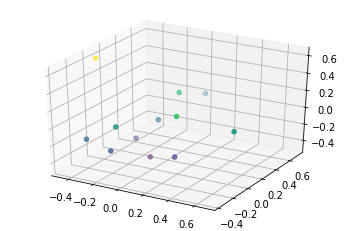

In [ ]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt



fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = z
xdata = x
ydata = y
ax.scatter3D(xdata, ydata, zdata, c=zdata);

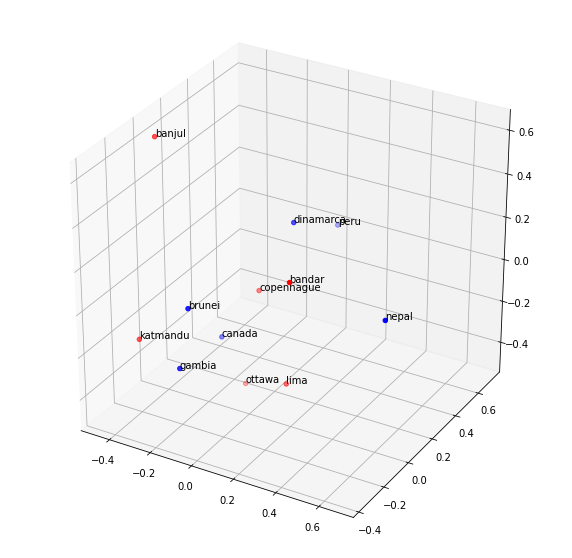

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

palabras = ['peru','nepal','brunei','canada','dinamarca','gambia','lima','katmandu','bandar','ottawa','copenhague','banjul']

# Data for three-dimensional scattered points
zdata = z
xdata = x
ydata = y
ax.scatter3D(xdata[0:6], ydata[0:6], zdata[0:6],color='b')
ax.scatter3D(xdata[6:], ydata[6:], zdata[6:],color='r')

for label in range(12):
    ax.text(x[label],y[label],z[label],palabras[label])

# Punto 6

In [ ]:
# create 6-bit hashes for input data of 8 dimensions:
lsh = lshash.LSHash(2, 1620)

for word in training_data:
    lsh.index(word[0])

In [ ]:
words = ['restos','mundo','antigua','comunidades','divide']
words_indx = [word_to_index[w] for w in words]
indx_vec = [training_data[i] for i in words_indx]

In [ ]:
top = 10
for word in indx_vec:
    vecinos = lsh.query(list(word[0]),num_results=top,distance_func='cosine')
    print([index_to_word[vecinos[i][0][0].index(1)] for i in range(len(vecinos))])

['de', 'enorme', 'nacionales', 'conocida', 'unico', 'soberania', 'remonta', 'siliguri', 'theory', 'pesar']
['al', 'resultado', 'sociales', 'golpe', 'inicio', 'paises', 'confrontacion', 'continente', 'cooperacion', 'oncenio']
['fueron', 'lima', 'disminuyeron', 'riqueza', 'siete', 'britanicas', 'mano', 'andes', 'contar', 'tradicion']
['lentamente', 'enorme', 'nacionales', 'conocida', 'unico', 'soberania', 'de', 'remonta', 'siliguri', 'theory']
['xviii', 'lima', 'disminuyeron', 'riqueza', 'siete', 'britanicas', 'mano', 'andes', 'contar', 'tradicion']
